## Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)

Speech audio-only files (16bit, 48kHz .wav) from the RAVDESS. 

Full dataset of speech and song, audio and video (24.8 GB) available from Zenodo( https://zenodo.org/record/1188976#.YfAv1upBxPY). 

Construction and perceptual validation of the RAVDESS is described in our Open Access paper in PLoS ONE.

Check out our Kaggle Song emotion dataset (https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio).

### Files

This portion of the RAVDESS contains 1440 files: **60 trials per actor x 24 actors = 1440**. 

The RAVDESS contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech emotions includes **calm, happy, sad, angry, fearful, surprise, and disgust** expressions. Each expression is produced at **two levels of emotional intensity (normal, strong)**, with an additional neutral expression.

### File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: `03-01-06-01-02-01-12.wav`

- Audio-only (03)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12)

Female, as the actor ID number is even.

### How to cite the RAVDESS

Academic citation

If you use the RAVDESS in an academic publication, please use the following citation: Livingstone SR, Russo FA (2018) The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS): A dynamic, multimodal set of facial and vocal expressions in North American English. PLoS ONE 13(5): e0196391. https://doi.org/10.1371/journal.pone.0196391.

All other attributions

If you use the RAVDESS in a form other than an academic publication, such as in a blog post, school project, or non-commercial product, please use the following attribution: "The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

In [98]:
import os, time, librosa, librosa.display
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [123]:
root_path = 'DataSource'
emotions_ref = [ 'Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised' ]

#### Output data set:

0. full file name
1. modality
2. vocal chanel
3. emotion
4. emotional intensity
5. statement
6. repetitions
7. actor index
8. gender (1 - female, 0 - male)

In [81]:
def create_source_dataset(root_path): 
    
    current_time = time.time()
    
    ds = []
    
    # get absolute root folder path
    root_abspath = os.path.join(os.path.abspath(os.getcwd()), root_path)    
    root_dirs = [os.path.join(root_abspath, x) for x in os.listdir(root_path)] 
    
    for root_dir in root_dirs:
        
        for file_src in os.listdir(root_dir):
            # 0 element
            file_path = os.path.join(root_dir, file_src)
            # 1 modality 0..2
            modality = int(file_src[0:2])
            # 2 vocal channel 3..5
            vocal_channel = int(file_src[3:5])
            # 3 emotion 6..8
            emotion = int(file_src[6:8])
            # 4 emotional intensity 9..11
            emotional_intensity = int(file_src[9:11])
            # 5 statement 12..14
            statement = int(file_src[12:14])
            # 6 repetitions 15..17
            repetions = int(file_src[15:17])
            # 7 actor index 18..20
            actor_id = int(file_src[18:20])
            gender = 0
            if actor_id % 2 == 0:
                gender = 1
                
            ds.append([file_path, modality, vocal_channel, emotion, 
                       emotional_intensity, statement, repetions, actor_id, gender])
            
    assert len(ds) == 1440, 'it must be 1440 files in the source'
    
    df = pd.DataFrame(ds, columns = ['FileSource', 
                                     'Modality', 
                                     'VocalChannel', 
                                     'Emotion', 
                                     'EmotionalIntensity',
                                     'Statement',
                                     'Repetions',
                                     'ActorId',
                                     'Gender'])    
    
    print('Data source array is prepared - {} c'.format(time.time() - current_time))
    
    return df

### Read audio file

In [66]:
'''
This function reads audio file and returns:


    y, sr = librosa.load(path, sr = 22050, mono = True, offset = 0.0, 
                 duration = None, dtype = <class 'numpy.float32'>, 
                 res_type = 'kaiser_best')
                 
         sr - target sampling rate. ‘None’ uses the native sampling rate
         
 Returns:
     y    - np.ndarray [shape=(n,) or (2, n)], audio time series
     sr   - number > 0 [scalar]. sampling rate of y 
 
'''
def read_audio(file_name):
    
    assert os.path.isfile(file_name), '{} file is not found'.format(file_name)
    
    return librosa.load(file_name, mono = True) 

In [146]:
def get_signal_mel(y, sr):
    
    melspec = librosa.feature.melspectrogram(y, sr = sr, n_mels = 256)
    melspec = librosa.power_to_db(melspec).astype(np.float32)
    
    return melspec

In [128]:
def get_samples(df_src):
    
    samples = []
    
    for i, row in df_src.iterrows():        
        emotion = emotions_ref[row[3] - 1]
        
        y, sr = read_audio(row[0])
        melspec = get_signal_mel(y, sr)
        
        samples.append([y, sr, melspec, emotion])
        
    return samples

### Visualizations

In [171]:
def show_samples(src):
    
    fig, ax = plt.subplots(len(src), 2, figsize = (20, 40))
    fig.tight_layout(pad = 5.0)    
    
    for i in range(len(src)):
        
        ax[i][0].set_title(src[i][3], fontsize = 18)
        ax[i][1].set_title(src[i][3], fontsize = 18)
        
        librosa.display.specshow(src[i][2], 
                                 x_axis = 'time',  
                                 y_axis = 'mel', 
                                 sr = src[i][1], 
                                 fmax = 48000, 
                                 ax = ax[i][0])
        
        librosa.display.waveshow(src[i][0],
                                 sr = src[i][1],
                                 ax = ax[i][1])

### Process

In [82]:
source = create_source_dataset(root_path)

Data source array is prepared - 0.02784872055053711 c


In [83]:
source.head()

,FileSource,Modality,VocalChannel,Emotion,EmotionalIntensity,Statement,Repetions,ActorId,Gender
0,d:\DataSource\speech_project\DataSource\Actor_...,3,1,1,1,1,1,1,0
1,d:\DataSource\speech_project\DataSource\Actor_...,3,1,1,1,1,2,1,0
2,d:\DataSource\speech_project\DataSource\Actor_...,3,1,1,1,2,1,1,0
3,d:\DataSource\speech_project\DataSource\Actor_...,3,1,1,1,2,2,1,0
4,d:\DataSource\speech_project\DataSource\Actor_...,3,1,2,1,1,1,1,0


In [166]:
df_src = source.query('ActorId == 1 and EmotionalIntensity == 1 and Repetions == 1 and Statement == 1')

In [167]:
samples = get_samples(df_src)

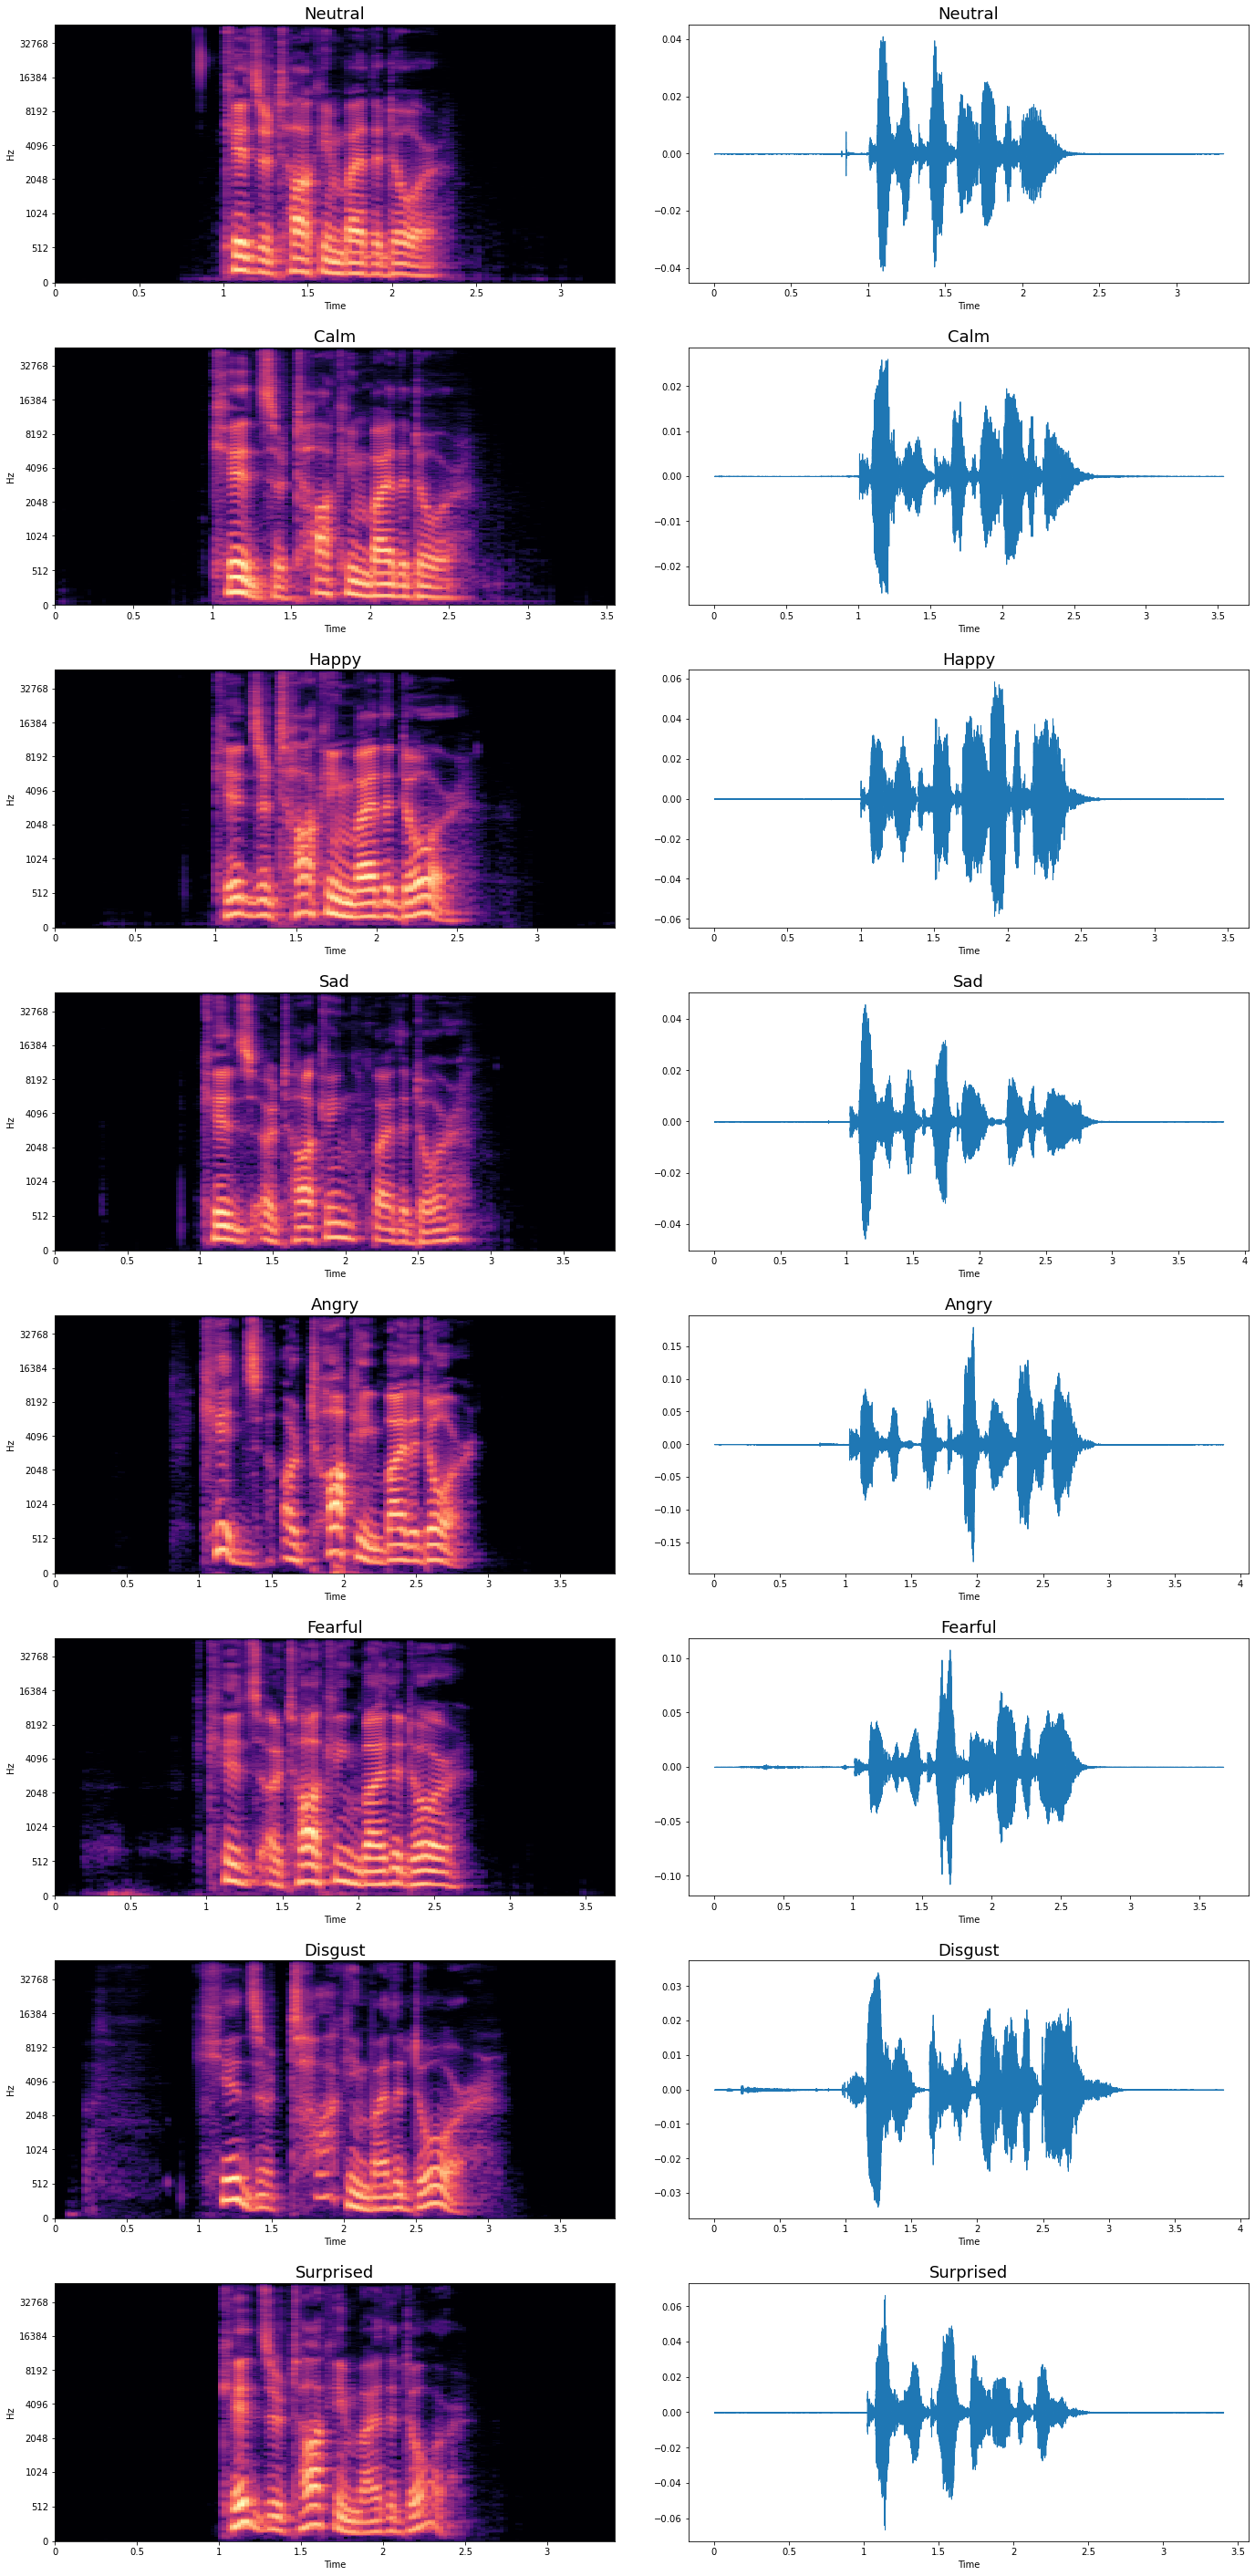

In [172]:
show_samples(samples)